In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/inputs3.zip

In [ ]:
!unzip /content/drive/MyDrive/outputs3.zip

In [ ]:
import numpy as np
import scipy, matplotlib
import tensorflow as tf
import time
import glob
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Conv2DTranspose, AveragePooling2D, GlobalAveragePooling2D, concatenate, Add, Activation, Reshape, Multiply, Input
from keras.datasets import mnist
import cv2
from matplotlib.colors import LogNorm
from keras.optimizers import Adam
import warnings
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn.exceptions import ConvergenceWarning
from keras import layers
import random
from PIL import Image

Data reading

In [ ]:
import cv2
import glob
import numpy as np

x = []
for img in glob.glob("/content/outputs3/*.png"):
    n = cv2.imread(img)
   # if n is None:
    #    print(f"Failed to read image: {img}")
     #   continue
    n = cv2.resize(n, (128, 128))  # Resize the image to (128, 128)
    x.append(n)

x_noise = []
for img in glob.glob("/content/inputs3/*.png"):
    n = cv2.imread(img)
    #if n is None:
     #   print(f"Failed to read image: {img}")
      #  continue
    n = cv2.resize(n, (128, 128))  # Resize the image to (128, 128)
    x_noise.append(n)

x = np.array(x, dtype=np.float32)
x = x.astype('float32') / 255.0
print(x.shape)

x_noise = np.array(x_noise, dtype=np.float32)
x_noise = x_noise.astype('float32') / 255.0
print(x_noise.shape)


(3199, 128, 128, 3)
(3199, 128, 128, 3)


In [ ]:
del x
del x_noise

(128, 128, 3)


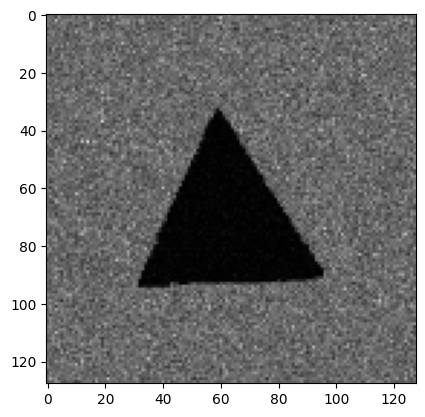

In [ ]:
plt.imshow(x_noise[8], cmap='gray')
print(x_noise[8].shape)

In [ ]:
print(x_noise[8])

Splitting into train and validation(test)

In [ ]:
x_train = x[0:2800]
x_test = x[2800:3199]

x_train_noisy = x_noise[0:2800]
x_test_noisy = x_noise[2800:3199]

In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)

x_train_noisy = np.array(x_train_noisy)
x_test_noisy = np.array(x_test_noisy)

In [ ]:
x_train = np.reshape(x_train,(x_train.shape[0],128,128,1))
x_test = np.reshape(x_test,(x_test.shape[0],128,128,1))
x_train_noisy = np.reshape(x_train_noisy,(x_train_noisy.shape[0],128,128,1))
x_test_noisy = np.reshape(x_test_noisy,(x_test_noisy.shape[0],128,128,1))

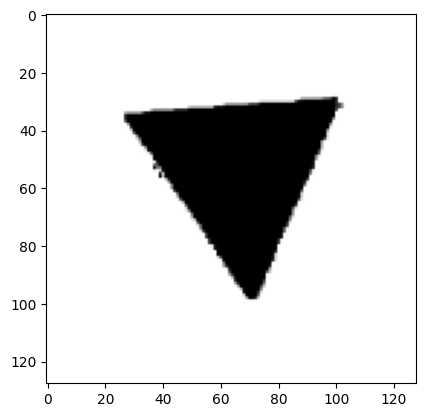

In [ ]:
plt.imshow(x_train[300], cmap="gray")

Model


In [ ]:
model = Sequential()
# encoder network
model.add(Conv2D(filters = 128, kernel_size = (2,2), activation = 'relu', padding = 'same', input_shape = (128,128,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (2,2), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (2,2),strides = (2,2), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters = 512, kernel_size = (2,2),strides = (2,2), activation = 'relu', padding = 'same'))



# decoder network
model.add(Conv2D(filters = 512, kernel_size = (2,2), activation = 'relu', padding = 'same'))

model.add(tf.keras.layers.Conv2DTranspose(filters = 512, kernel_size = (2,2), strides = (2,2),activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (2,2), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (2,2), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (2,2), activation = 'relu', padding = 'same'))


model.add(tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = (2,2),strides = (2,2), activation = 'relu', padding = 'same'))
model.add(Conv2D(filters = 64, kernel_size = (2,2), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.BatchNormalization())

model.add(Conv2D(filters = 3, kernel_size = (2,2), activation = 'relu', padding = 'same'))


# to get the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     1664      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 128)    512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     65664     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 128)    512       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 256)       131328    
                                                                 
 batch_normalization_2 (Batc  (None, 64, 64, 256)      1

Training

In [ ]:
OPTIMIZER =  tf.keras.optimizers.Adam(learning_rate = 0.001)
LOSS = 'mean_squared_error'
model.compile(optimizer =OPTIMIZER, loss = LOSS, metrics = ['accuracy'])

In [ ]:
EPOCHS = 10
BATCH_SIZE = 64
VALIDATION = (x_test_noisy, x_test)
history = model.fit(x_train_noisy, x_train,batch_size = BATCH_SIZE,epochs = EPOCHS, validation_data = VALIDATION)

Epoch 1/10
44/44 [==============================] - 17s 397ms/step - loss: 0.0025 - accuracy: 0.4879 - val_loss: 0.0020 - val_accuracy: 0.9562
Epoch 2/10
44/44 [==============================] - 17s 393ms/step - loss: 0.0034 - accuracy: 0.5489 - val_loss: 0.0045 - val_accuracy: 0.9843
Epoch 3/10
44/44 [==============================] - 17s 394ms/step - loss: 0.0027 - accuracy: 0.5329 - val_loss: 0.0033 - val_accuracy: 0.9653
Epoch 4/10
44/44 [==============================] - 17s 394ms/step - loss: 0.0025 - accuracy: 0.5535 - val_loss: 0.0023 - val_accuracy: 0.9807
Epoch 5/10
44/44 [==============================] - 17s 394ms/step - loss: 0.0028 - accuracy: 0.4671 - val_loss: 0.0021 - val_accuracy: 0.9169
Epoch 6/10
44/44 [==============================] - 17s 394ms/step - loss: 0.0021 - accuracy: 0.4741 - val_loss: 0.0017 - val_accuracy: 0.9184
Epoch 7/10
44/44 [==============================] - 17s 394ms/step - loss: 0.0024 - accuracy: 0.4684 - val_loss: 0.0020 - val_accuracy: 0.9797

Testing

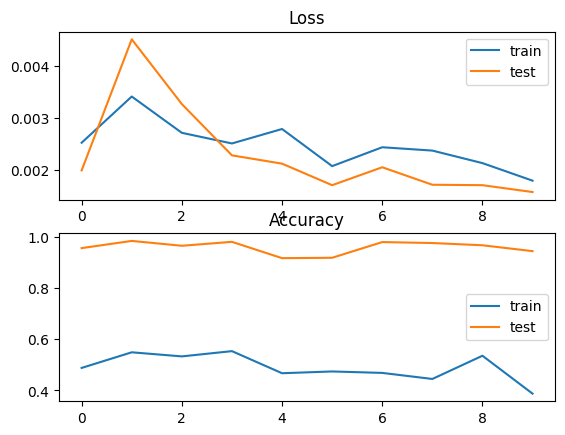

In [ ]:
from matplotlib import pyplot
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
#plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

(128, 128, 3)
1/1 [==============================] - 0s 21ms/step


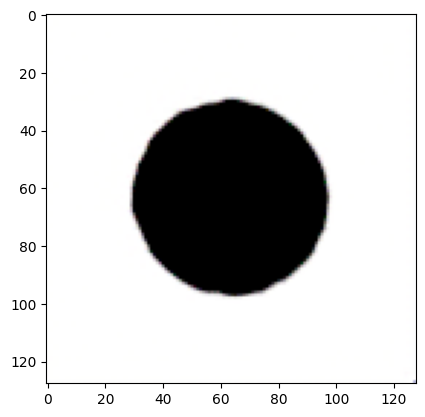

In [ ]:
t = []
n= cv2.imread("/content/0.png")
n = cv2.resize(n, (128, 128))
t.append(n)
t = np.array(t, dtype=np.float32)
t = t.astype('float32')/255
print(t[0].shape)
a = np.expand_dims(t[0],axis=0)
pred = model.predict(a)
pred = np.reshape(pred,(128,128,3))
plt.imshow(pred, cmap="gray")

In [ ]:
predd = pred*255
cv2.imwrite('pred.png', predd)

True